<!-- dom:TITLE: Higher order sensitivity indices for interaction models -->
# Higher order sensitivity indices for interaction models

In [1]:
# ipython magic
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

# plot configuration
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# import seaborn as sns # sets another style
matplotlib.rcParams['lines.linewidth'] = 3
fig_width, fig_height = (7.0,5.0)

matplotlib.rcParams['figure.figsize'] = (fig_width, fig_height)

# font = {'family' : 'sans-serif',
#         'weight' : 'normal',
#         'size'   : 18.0}
# matplotlib.rc('font', **font)  # pass in the font dict as kwar

In [3]:
# import modules
import numpy as np
import chaospy as cp
from monte_carlo import generate_sample_matrices_mc
from monte_carlo import calculate_sensitivity_indices_mc
from xlwt.Utils import col_by_name

# A model with interaction
<div id="sec:non_additive_model"></div>

For convenience and simplicity, we consider the same model as before:

<!-- Equation labels as ordinary links -->
<div id="eq:non_add_model"></div>

$$
\begin{equation}
Y = \sum_{i=1}^{r} \Omega_i \, Z_i
\label{eq:non_add_model} \tag{1}
\end{equation}
$$

The only difference is that we render ([eq:non_add_model](#eq:non_add_model))
non-additive by letting both $\Omega_i$ and $Z_i$ be random
variables. By doing so our model will have products of two distinct
random variables, and consequently it will be a non-additive model, as defined below:



<hr/>
**Definition: Additive model.**

An [additive model](https://chemicalstatistician.wordpress.com/2014/03/07/applied-statistics-lesson-of-the-day-additive-models-vs-interaction-models-in-2-factor-experimental-designs/) is the arithmetic sum of its individual random variables.
<hr/>



In constrast, a `non-additive model`, is `not` simply a sum of its individual
random variables. For our model ([eq:non_add_model](#eq:non_add_model)) the effect of
$Z_i$ on $Y$ depends on the value of $\Omega_i$, and for this reason
non-additive moldels are also often called `interaction models`.

Note that $ Y = \sum_{i=1}^{r} \Omega_i \, Z_i^2$, is an additive
model for constant $\Omega_i$, but non-linear in the individual $Z_i$.

For our non-additive (interaction) model ([eq:non_add_model](#eq:non_add_model)) we
assume $\Omega_i$ and $Z_i$ to be normaly distributed random
variables:

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
Z_i  \sim N(0, \sigma_{Z_i}), \qquad i=1,2, \ldots, r 
\label{_auto1} \tag{2}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation} 
\Omega_i  \sim N(\mu_{\Omega_i}, \sigma_{\Omega_i})
\label{_auto2} \tag{3}
\end{equation}
$$

This means that the distributions of $Z_i$ are unchanged, whereas the
mean values $\mu_{\Omega_i}$ of the distributions of $\Omega_i$ are
chosen to be non-zero:

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
\mu_{\Omega_i} = 0.5 i, \qquad i=1,2, \ldots, r \qquad \textsf{such that} \qquad
\bar{\Omega}_1 < \bar{\Omega}_3 < \bar{\Omega}_3 <\bar{\Omega}_4
\label{_auto3} \tag{4}
\end{equation}
$$

The number of random variables for our interaction model
([eq:non_add_model](#eq:non_add_model)) has increased to $N_{rv} = 2\, r$ and we arrange them in a vector in the following manner:

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\mathbf{X}= \left ( Z_1, Z_2, \ldots, Z_r, \Omega_1, \Omega_2, \ldots, \Omega_r \right)
\label{_auto4} \tag{5}
\end{equation}
$$

Below we will demonstrate how the Sobol sensitivity indices may be
computed with both the Monte Carlo Method and the Polynomial Chaos
method. The python code for the model is:

In [4]:
# start the linear model
def linear_model(w, z):
    return np.sum(w*z, axis=1)

### Definition of the random input variables

In this example of interaction models we set $r=4$ in
([eq:non_add_model](#eq:non_add_model)) and in the code snippet below we let the
numpy-arrays `zm` and `wm` hold the expectations in the first column
and the standard deviation in the second column of $Z_i$ and
$\Omega_i$, repectively. You may uncomment the lines in the code
snippet to set values of e.g. the standard deviations yourself.

In [5]:
    # definition of mu and sig for z and w
    N_terms = 4
    c = 0.5
    zm = np.array([[0., i] for i in range(1, N_terms+1)])
    wm = np.array([[i * c, i] for i in range(1, N_terms+1)])

    # to see the effect of changing the values in zm uncomment and change one of these lines and re-run

    # zm[0, 1] = 1
    # zm[1, 1] = 20
    # zm[2, 1] = 3
    # zm[3, 1] = 10

In this example we choose to set $r=4$ and use the chaospy package to
define our random input variables for our model
([eq:non_add_model](#eq:non_add_model)). The function `generate_distributions` takes
two numpy-arrays `zm` and `wm` as arguments, where `wm` is
optional. Whenever `wm` is passed to the function (not `None`) it is
treated as an array holding the expectation and standard deviations as
`zm` and appended to the `xm` array to hold all the expectations and
standard deviations for both $Z_i$ and $\Omega_i$. The marginal
distributions (or probability density functions or pdf for short) for each element in `xm` are generated with repeated calls to chaospy for each elmement in `xm`: `[cp.Normal(*mu_sig) for mu_sig in xm]`. Note that the `*-operator` is used to unpack the arguments out of a list or tuple.   

Finally, we generate the the joint pdf by unpacking all the elements
in the list `marginal distributions` and passing them to `cp.J`, the
joint probability density function of Chaospy.

In [6]:
# definition of the distributions
def generate_distributions(zm, wm=None):
    # define marginal distributions
    if wm is not None:
        zm = np.append(zm, wm, axis=0)
    marginal_distributions = [cp.Normal(*mu_sig) for mu_sig in zm]
    # define joint distributions
    jpdf = cp.J(*marginal_distributions)

    return jpdf

# Scatter plots

In [7]:
    # generate the joint distribution
    jpdf = generate_distributions(zm, wm)

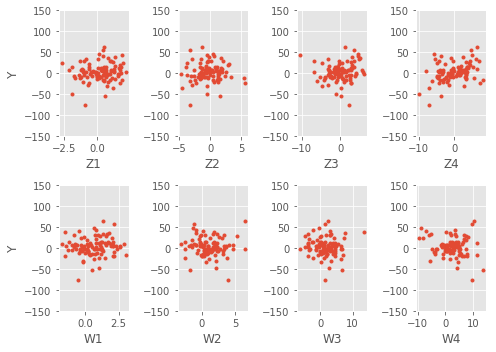

In [8]:
    # Scatter plots of data for visual inspection of sensitivity
    N_plot=100
    N_prms = len(jpdf)
    N_terms = N_prms//2

    Xs=jpdf.sample(N_plot,sample_method='R').transpose()  
    Zs = Xs[:, :N_terms]  # Split X in two vectors for X and W
    Ws = Xs[:, N_terms:]
    Ys = linear_model(Ws, Zs)

    scatter = plt.figure('Scatter plots')
    for k in range(N_terms):
        plt.subplot(2, N_terms, k + 1)
        _=plt.plot(Zs[:, k], Ys[:], '.')
        if k==0 : plt.ylabel('Y')
        plt.xlabel('Z{}'.format(k+1))
        plt.ylim([-150, 150])

        plt.subplot(2, N_terms, k + 1 + N_terms)
        _=plt.plot(Ws[:, k], Ys[:], '.')
        if k==0 : plt.ylabel('Y')
        plt.xlabel('W{}'.format(k+1))
        plt.ylim([-150, 150])
    scatter.tight_layout()

# First order sensitivity coefficients

### Analytical computation of the sensitivity indices

The calculation of the sensitivity indices for this model can be done analytically.
We will use this as reference for the comparison with the results of the Monte Carlo and polynomial chaos method.

In [9]:
    # calculate the analytic sensitivity coefficients

    VarY = np.sum(zm[:, 1]**2 * (wm[:, 0]**2 + wm[:, 1]**2), axis=0)
    Sz = wm[:, 0]**2 * zm[:, 1]**2/VarY # first order indices
    Sw = np.zeros_like(Sz)
    Szw= wm[:, 1]**2 * zm[:, 1]**2/VarY  # second order indices
    StZ = (wm[:, 0]**2 * zm[:, 1]**2 + wm[:, 1]**2 * zm[:, 1]**2)/VarY # total indices
    Stw = (wm[:, 1]**2 * zm[:, 1]**2)/VarY

    # join sensitivity arrays
    Sa = np.append(Sz, Sw)
    Sta = np.append(StZ, Stw)

Now we will calculate of the sensitivity indices with both the Monte Carlo and polynomial chaos method:

### Define functions for computing the sensitivity indices with the MCM

In [10]:
# calculate sens indices of non additive model
def monte_carlo_sens_nonlin(Ns, jpdf, sample_method='R'):

    N_prms = len(jpdf)

    # 1. Generate sample matrices
    XA, XB, XC = generate_sample_matrices_mc(Ns, N_prms, jpdf, sample_method)

    # 2. Evaluate the model
    Y_A, Y_B, Y_C = evaluate_non_additive_linear_model(XA, XB, XC)

    # 3. Approximate the sensitivity indices
    S, ST = calculate_sensitivity_indices_mc(Y_A, Y_B, Y_C)

    return XA, XB, XC, Y_A, Y_B, Y_C, S, ST
# end calculate sens indices of non additive model


# model evaluation
def evaluate_non_additive_linear_model(X_A, X_B, X_C):

    N_prms = X_A.shape[1]
    Ns = X_A.shape[0]
    N_terms = int(N_prms / 2)
    # 1. evaluate sample matrices X_A
    Z_A = X_A[:, :N_terms]  # Split X in two vectors for X and W
    W_A = X_A[:, N_terms:]
    Y_A = linear_model(W_A, Z_A)

    # 2. evaluate sample matrices X_B
    Z_B = X_B[:, :N_terms]
    W_B = X_B[:, N_terms:]
    Y_B = linear_model(W_B, Z_B)

    # 3. evaluate sample matrices X_C
    Y_C = np.empty((Ns, N_prms))
    for i in range(N_prms):
        x = X_C[i, :, :]
        z = x[:, :N_terms]
        w = x[:, N_terms:]
        Y_C[:, i] = linear_model(w, z)

    return Y_A, Y_B, Y_C

### Define functions for computing the sensitivity indices with polynomial chaos expansions

In [11]:
# polynomial chaos sensitivity analysis
def polynomial_chaos_sens(Ns_pc, jpdf, polynomial_order, poly=None, return_reg=False):
    N_terms = int(len(jpdf) / 2)
    # 1. generate orthogonal polynomials
    poly = poly or cp.orth_ttr(polynomial_order, jpdf)
    # 2. generate samples with random sampling
    samples_pc = jpdf.sample(size=Ns_pc, rule='R')
    # 3. evaluate the model, to do so transpose samples and hash input data
    transposed_samples = samples_pc.transpose()
    samples_z = transposed_samples[:, :N_terms]
    samples_w = transposed_samples[:, N_terms:]
    model_evaluations = linear_model(samples_w, samples_z)
    # 4. calculate generalized polynomial chaos expression
    gpce_regression = cp.fit_regression(poly, samples_pc, model_evaluations)
    # 5. get sensitivity indices
    Spc = cp.Sens_m(gpce_regression, jpdf)
    Stpc = cp.Sens_t(gpce_regression, jpdf)
    
    if return_reg:
        return Spc,Stpc,gpce_regression    
    else:
        return Spc, Stpc

### Perform the computations

**MCM**

In [12]:
    # Monte Carlo
    #Ns_mc = 1000000 # Number of samples mc
    Ns_mc = 10000 # Number of samples mc
    # calculate sensitivity indices with mc
    A_s, B_s, C_s, f_A, f_B, f_C, Smc, Stmc = monte_carlo_sens_nonlin(Ns_mc, jpdf)

**Polynomial chaos**

In [13]:
    # compute with Polynomial Chaos
    Ns_pc = 200
    polynomial_order = 3
    
    # calculate sensitivity indices with gpc
    Spc, Stpc, gpce_reg = polynomial_chaos_sens(Ns_pc, jpdf, polynomial_order,return_reg=True)

**Compare the computations**

In [14]:
    # compare the computations
    import pandas as pd
    row_labels  = ['X_'+str(x) for x in range(1,N_terms*2+1)]
    S=np.column_stack((Sa,Spc,Smc,Sta,Stpc,Stmc))
    S_table = pd.DataFrame(S, columns=['Sa','Spc','Smc','Sta','Stpc','Stmc'], index=row_labels)  
    print(S_table.round(3))

        Sa    Spc    Smc    Sta   Stpc   Stmc
X_1  0.001  0.001  0.001  0.003  0.003 -0.010
X_2  0.009  0.009  0.008  0.045  0.045  0.030
X_3  0.046  0.046  0.042  0.229  0.229  0.211
X_4  0.145  0.145  0.152  0.723  0.723  0.720
X_5  0.000  0.000 -0.000  0.002  0.002 -0.010
X_6  0.000  0.000 -0.002  0.036  0.036  0.026
X_7  0.000  0.000 -0.006  0.183  0.183  0.172
X_8  0.000  0.000  0.006  0.579  0.579  0.559


# Second and higher order sensitivity coefficients

In the [sensitivity introduction notebook](sensitivity_introduction.ipynb) 
we introduced the first order sensitivity indices as:

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
S_i = \frac{\text{V}_{Z_i}(E_{Z_{\sim i}} (Y\;|\;Z_i))}{\text{V}(Y)}
\label{_auto5} \tag{6}
\end{equation}
$$

Based on the seminal works of the Russian mathematician Sobol, we may
introduce variance decompositions of the form:

<!-- Equation labels as ordinary links -->
<div id="eq:Vi"></div>

$$
\begin{equation}
V_i = V \left ( E(Y\,|\, X_i) \right ) \label{eq:Vi} \tag{7} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:Vij"></div>

$$
\begin{equation} 
V_{ij} = V \left ( E(Y\,|\, X_i, X_j) \right )  - V_i - V_j = V_{ij}^c - V_i - V_j\label{eq:Vij} \tag{8} 
\end{equation}
$$

where we for convenience have dropped the subscripts for the
expectation operator and the variance operator, and use the shorthand
notation $V_{ij}^c= V \left ( E(Y\,|\, X_i, X_j) \right )$ . Keep in
mind that the outer operator always operates on the conditioned
factors, in this case $X_i$ and $X_j$.

   * The second order conditional variance $V_{ij}^c=V \left ( E(Y\,|\, X_i, X_j) \right )$ is a measure of the combined effect of the pair $(X_i,X_j)$.

   * The $V_{ij}$ is interaction term between the factors $X_i$ and $X_j$ and the combined effect minus the first order effetcs $V_i$ and $V_j$.

   * The $V_{ij}$ captures the part of $V(Y)$ which cannot be expressed as a sum of the separate effects of $X_i$ and $X_j$

By repeated introduction of progressively higher order conditional
variences, the total variance of the output $V(Y)$ may be presented as
a ANOVA-HDMR decomposition:

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
V(Y) = \sum_{i} V_i +\sum_{i}\sum_{j>i} V_{ij}+ \sum_{i}\sum_{j>i}\sum_{l>j} V_{ijl}+\ldots + V_{12...k}
\label{_auto6} \tag{9}
\end{equation}
$$

which by division of $V(Y)$ yields the very useful relation:

<!-- Equation labels as ordinary links -->
<div id="eq:S_decomp"></div>

$$
\begin{equation}
\sum_{i} S_i +\sum_{i}\sum_{j>i} S_{ij}+ \sum_{i}\sum_{j>i}\sum_{l>j} S_{ijl}+\ldots + S_{12...k} =1 \label{eq:S_decomp} \tag{10}
\end{equation}
$$

and then naturally expressed we find expessions for the 

**Second order indices:**

<!-- Equation labels as ordinary links -->
<div id="eq:Sij"></div>

$$
\begin{equation}
S_{ij} = \frac{V_{ij}^c}{V(Y)} - S_i - S_j
\label{eq:Sij} \tag{11}
\end{equation}
$$

**Higher order sensitivity indices**

The variance-based sensitivity indices in ([eq:S_decomp](#eq:S_decomp)) represent
a way to express 100% of the variance of $Y$ regardless of whether $Y$
is additive or non-additive. In other words, ([eq:S_decomp](#eq:S_decomp))
provides a complete quantification of the sensitivity of the model
with respect to its predictive factors. The only problem is that
([eq:S_decomp](#eq:S_decomp)) may have as many as $2^k-1$ terms for $k$ input factors.

  * For $k=3$ this gives $2^3-1=7$ indices: $S_1$, $S_2$, $S_3$,$S_{12}$, $S_{13}$, $S_{23}$, $S_{123}$,

  * For $k=10$ we get $2^{10}-1=1023$ indices, which is neither tractable and informative in practice. 

Of the $2^k-1$ terms we have:
  * $k$ first order indices $S_i$

  * $ {k\choose 2} =\frac{k!}{2!\,(k-2)!}$ second order indices $S_{ij}$

  * $ {k\choose 3}$ third order indices $S_{ijk}$

  * ..and so on

The computation of the second order indices for our model example is
illustrated in the code snippet below. For our simple model,
interaction terms higher than second order will be zero. Consequently,
by ([eq:S_decomp](#eq:S_decomp)) the sum of the first and second order indicecs
should sum up to unity. We test that this is indeed the case by
printing the sum. Further, we compute the error for the indices
computed with `chaospy` for each individual index.

In [15]:
    # Second order indices with gpc
    
    S2 = cp.Sens_m2(gpce_reg, jpdf) # second order indices with gpc
    
    # print all second order indices
    print(pd.DataFrame(S2,columns=row_labels,index=row_labels).round(3))
    
    # sum all second order indices 
    SumS2=np.sum(np.triu(S2))
    print('\nSum Sij = {:2.2f}'.format(SumS2))
    
    # sum all first and second order indices
    print('Sum Si + Sij = {:2.2f}\n'.format(np.sum(Spc)+SumS2))
    
    # compare nonzero second order indices with analytical indices 
    Szw_pc=[S2[i,i+N_terms] for i in range(N_terms) ]
    Szw_table=np.column_stack((Szw_pc,Szw,(Szw_pc-Szw)/Szw))
    print(pd.DataFrame(Szw_table,columns=['Szw','Szw pc','Error%']).round(3))

       X_1    X_2    X_3    X_4    X_5    X_6    X_7    X_8
X_1  0.000  0.000  0.000  0.000  0.002  0.000 -0.000 -0.000
X_2  0.000  0.000  0.000  0.000 -0.000  0.036 -0.000 -0.000
X_3  0.000  0.000  0.000 -0.000 -0.000 -0.000  0.183 -0.000
X_4  0.000  0.000 -0.000  0.000  0.000 -0.000  0.000  0.579
X_5  0.002 -0.000 -0.000  0.000  0.000  0.000  0.000  0.000
X_6  0.000  0.036 -0.000 -0.000  0.000  0.000  0.000  0.000
X_7 -0.000 -0.000  0.183  0.000  0.000  0.000  0.000  0.000
X_8 -0.000 -0.000 -0.000  0.579  0.000  0.000  0.000  0.000

Sum Sij = 0.80
Sum Si + Sij = 1.00

     Szw  Szw pc  Error%
0  0.002   0.002     0.0
1  0.036   0.036    -0.0
2  0.183   0.183    -0.0
3  0.579   0.579     0.0


The important thing to realize is that the number of interaction terms
increase exponentialy as the number of input factors $k$ increase.  In
this case, the remedy offered by variance based analysis is to compute
the 'total effect term', which we will outline in the following.

# Total effects

In this section we will introduce the total effects index $S_{T_i}$,
which accounts for the complete contribution of the input factor $X_i$
to the variation in the output $V(Y)$. This means that $S_{T_i}$
includes first-order effects as well as all higher-order effects due
to interaction of $X_i$ with the other input factors.

One way to derive $S_{Ti}$, is to use Eve's Law of total variance and condition with respect to all factors but one, i.e. $X_{\sim i}$:

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
V(Y) = V(E(Y|X_{\sim i})) + E(V(Y|X_{\sim i}))
\label{_auto7} \tag{12}
\end{equation}
$$

The metric $V(Y) - V(E(Y|X_{\sim i})) = E(V(Y|X_{\sim i}))$ is the
portion of the variance of $Y$ that would remain, on average, if the
values of $X_{\sim i}$ were given or fixed. Remember that the
averaging is conducted over the full range of $X_{\sim i}$, as they in
reality are uncertain and their true values unknown. By dividing this
metric by the total variance $V(Y)$, we get and index or ratio which
relates this metric to the total variance of $Y$:

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
S_{Ti} = \frac{V(Y) - V(E(Y|X_{\sim i})}{V(Y)}
\label{_auto8} \tag{13}
\end{equation}
$$

## Summary of variance based sensitivity indices

  * The first order index $S_i$ indicate how much on could reduce the
    output variace of $Y$, on average, if $X_i$ could be fixed.

  * The total effect index $S_{Ti}$, is larger or equal to
    $S_i$. Equality results when $X_i$ there are no interaction between the factors.

  * The difference $S_{Ti}-S_i$ is a metric of the interactions of $X_i$ with other input factors.

  * $S_{Ti}=0$ implies that output $Y$ is insensitive to variations in $X_i$, and that it thus can be fixed.

  * $\sum_i S_i = 1$ for additive models, and $\sum_i S_i < 1$ for models with interaction.

  * $\sum_i S_{Ti} \geq 1$. The summuation is one only in the case of a perfectly additive model.

# Convergence Analysis
## Monte Carlo Method
This may take a while. Be patient!
(You can also reduce iteration number for averaging.)

Convergence analysis for the monte carlo method:

In [16]:
        # Convergence Monte Carlo with random sampling
        list_of_samples = np.array([10000, 50000, 100000, 500000, 1000000])
        s_mc_err = np.zeros((len(list_of_samples), N_prms))
        st_mc_err = np.zeros((len(list_of_samples), N_prms))
        # average over
        N_iter = 5
        print('MC convergence analysis:')
        for i, N_smpl in enumerate(list_of_samples):
            print('    N_smpl {}'.format(N_smpl))
            for j in range(N_iter):
                A_s, XB, XC, Y_A, Y_B, Y_C, S, ST = monte_carlo_sens_nonlin(N_smpl,
                                                                                jpdf,
                                                                                sample_method='R')
                s_mc_err[i] += np.abs(S - Sa)
                st_mc_err[i] += np.abs(ST - Sta)
                print('         finished with iteration {} of {}'.format(1 + j, N_iter))
            s_mc_err[i] /= float(N_iter)
            st_mc_err[i] /= float(N_iter)
        # Plot results for monte carlo
        fig_random = plt.figure('Random sampling - average of indices')
        fig_random.suptitle('Random sampling - average of indices')

        ax = plt.subplot(1, 2, 1)
        plt.title('First order sensitivity indices')
        _=plt.plot(list_of_samples / 1000, np.sum(s_mc_err, axis=1), '-')
        ax.set_yscale('log')
        _=plt.ylabel('abs error')
        _=plt.xlabel('number of samples [1e3]')

        ax1 = plt.subplot(1, 2, 2)
        plt.title('Total sensitivity indices')
        _=plt.plot(list_of_samples / 1000, np.sum(st_mc_err, axis=1), '-')
        ax1.set_yscale('log')
        _=plt.ylabel('abs error')
        _=plt.xlabel('number of samples [1e3]')

Plotting the individual sensitivity indices:

In [17]:
        # Plot results for monte carlo figure individual
        fig_random = plt.figure('Random sampling')
        fig_random.suptitle('Random sampling')
        for l, (s_e, st_e) in enumerate(zip(s_mc_err.T, st_mc_err.T)):
            ax = plt.subplot(1, 2, 1)
            plt.title('First order sensitivity indices')
            plt.plot(list_of_samples / 1000, s_e, '-', label='S_{}'.format(l))
            ax.set_yscale('log')
            _=plt.ylabel('abs error')
            _=plt.xlabel('number of samples [1e3]')
            _=plt.legend()

            ax1 = plt.subplot(1, 2, 2)
            plt.title('Total sensitivity indices')
            _=plt.plot(list_of_samples / 1000, st_e, '-', label='ST_{}'.format(l))
            ax1.set_yscale('log')
            _=plt.ylabel('abs error')
            _=plt.xlabel('number of samples [1e3]')
            plt.legend()

## Polynomial Chaos
(Note how much faster this is.)
Convergence analysis for the polynomial chaos method:

In [18]:
        # Convergence Polynomial Chaos
        list_of_samples = np.array([140, 160, 200, 220])
        s_pc_err = np.zeros((len(list_of_samples), N_prms))
        st_pc_err = np.zeros((len(list_of_samples), N_prms))
        polynomial_order = 3
        # average over
        N_iter = 4
        print('PC convergence analysis:')
        poly = cp.orth_ttr(polynomial_order, jpdf)
        for i, N_smpl in enumerate(list_of_samples):
            print('    N_smpl {}'.format(N_smpl))
            for j in range(N_iter):
                # calculate sensitivity indices
                Spc, Stpc = polynomial_chaos_sens(N_smpl, jpdf, polynomial_order, poly)
                s_pc_err[i] += np.abs(Spc - Sa)
                st_pc_err[i] += np.abs(Stpc - Sta)
                print('         finished with iteration {} of {}'.format(1 + j, N_iter))
            s_pc_err[i] /= float(N_iter)
            st_pc_err[i] /= float(N_iter)

        # Plot results for polynomial chaos
        fig_random = plt.figure('Polynomial Chaos - average of indices')
        fig_random.suptitle('Polynomial Chaos - average of indices')

        ax = plt.subplot(1, 2, 1)
        plt.title('First order sensitivity indices')
        _=plt.plot(list_of_samples, np.sum(s_pc_err, axis=1), '-')
        ax.set_yscale('log')
        _=plt.ylabel('abs error')
        _=plt.xlabel('number of samples [1e3]')

        ax1 = plt.subplot(1, 2, 2)
        plt.title('Total sensitivity indices')
        _=plt.plot(list_of_samples, np.sum(st_pc_err, axis=1), '-')
        ax1.set_yscale('log')
        _=plt.ylabel('abs error')
        _=plt.xlabel('number of samples [1e3]')

Plotting the individual sensitivity indices:

In [19]:
        # Plot results for polynomial chaos individual
        fig_random = plt.figure('Polynomial Chaos')
        fig_random.suptitle('Polynomial Chaos')
        for l, (s_e, st_e) in enumerate(zip(s_pc_err.T, st_pc_err.T)):
            ax = plt.subplot(1, 2, 1)
            plt.title('First order sensitivity indices')
            _=plt.plot(list_of_samples, s_e, '-', label='S_{}'.format(l))
            ax.set_yscale('log')
            plt.ylabel('abs error')
            plt.xlabel('number of samples [1e3]')
            plt.legend()

            ax1 = plt.subplot(1, 2, 2)
            plt.title('Total sensitivity indices')
            _=plt.plot(list_of_samples, st_e, '-', label='ST_{}'.format(l))
            ax1.set_yscale('log')
            plt.ylabel('abs error')
            plt.xlabel('number of samples [1e3]')
            plt.legend()